# Yolov5

https://github.com/ultralytics/yolov5.git


## setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import cv2
import torch
import yaml

- 주차장 dataset 

https://public.roboflow.com/object-detection/pklot



In [ ]:
%cd /content
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
%pip install -qr requirements.txt

import torch
from IPython.display import Image, clear_output

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 14927, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 14927 (delta 7), reused 6 (delta 0), pack-reused 14908
Receiving objects: 100% (14927/14927), 14.00 MiB | 17.48 MiB/s, done.
Resolving deltas: 100% (10254/10254), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.3 MB/s eta 0:00:00


In [ ]:
%mkdir /content/yolov5/pklot
%cd /content/yolov5/pklot

mkdir: cannot create directory ‘/content/yolov5/pklot’: File exists
/content/yolov5/pklot


In [ ]:
!curl -L 'https://public.roboflow.com/ds/uPtrFUOuil?key=7LORJCWW06' > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
%cat README.roboflow.txt


PKLot - v2 640

This dataset was exported via roboflow.ai on January 5, 2021 at 9:45 PM GMT

It includes 12416 images.
Spaces are annotated in YOLO v5 PyTorch format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 640x640 (Stretch)

No image augmentation techniques were applied.




In [ ]:
!dir

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [ ]:
from glob import glob # 사용자가 제시한 조건에 맞는 파일명을 리스트로 반환

train_img_list = glob('/content/yolov5/pklot/train/images/*.jpg')
test_img_list = glob('/content/yolov5/pklot/test/images/*.jpg')
valid_img_list = glob('/content/yolov5/pklot/valid/images/*.jpg') # 이 데이터셋은  validation set이 없음
print(len(train_img_list),len(test_img_list),len(valid_img_list))

8691 1242 2483


In [ ]:
# 만든 리스트를 txt파일로 저장
with open('/content/yolov5/pklot/train.txt', 'w') as f:
  f.write('\n'.join(train_img_list)+'\n')

with open('/content/yolov5/pklot/test.txt', 'w') as f:
  f.write('\n'.join(test_img_list)+'\n')

with open('/content/yolov5/pklot/val.txt', 'w') as f:
  f.write('\n'.join(valid_img_list)+'\n')  

In [ ]:
# 파일에 내용을 쓰는 함수
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic # decorator
def writetemplate(line,cell):
  with open(line,'w') as f:
    f.write(cell.format(**globals())) ## **는 dictionary type을 의미

In [ ]:
%cat /content/yolov5/pklot/data.yaml

train: ../train/images
val: ../valid/images

nc: 2
names: ['space-empty', 'space-occupied']

In [ ]:
%%writetemplate /content/yolov5/pklot/data.yaml
train: ./pklot/train.txt
test: ./pklot/test.txt
val: ./pklot/val.txt

nc: 2
names: ['space-empty', 'space-occupied']

In [ ]:
%cat /content/yolov5/pklot/data.yaml

train: ./pklot/train.txt
test: ./pklot/test.txt
val: ./pklot/val.txt

nc: 2
names: ['space-empty', 'space-occupied']


In [ ]:
# 모델 구성
import yaml
with open('/content/yolov5/pklot/data.yaml', 'r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])

%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
num_classes

'2'

In [ ]:
%%time
%cd /content/yolov5
!python train.py --img 640 --batch 64 --epochs 5 --data ./pklot/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name pklot_results --cache

/content/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=./pklot/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=pklot_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-56-gc0ca1d2 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
# 검증
# --task 설정 안해주면 default롤 'val'이 적용된다.
# 여기선 validation data를 사용
!python val.py --weights runs/train/pklot_results/weights/best.pt --data ./pklot/data.yaml --img 640  

val: data=./pklot/data.yaml, weights=['runs/train/pklot_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-55-g632bf48 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/yolov5/pklot/val.cache... 2483 images, 59 backgrounds, 0 corrupt: 100% 2483/2483 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 78/78 [01:30<00:00,  1.16s/it]
                   all       2483     143316      0.933      0.946      0.954      0.519
           space-empty       2483      73629      0.923      0.922      0.959      0.528
        space-occupi

In [ ]:
#test validation
# 여기서는 test data를 사용하게 설정
!python val.py --weights runs/train/pklot_results/weights/best.pt --data ./pklot/data.yaml --img 640 --task test

val: data=./pklot/data.yaml, weights=['runs/train/pklot_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-55-g632bf48 Python-3.8.16 torch-1.13.0+cu116 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/yolov5/pklot/test... 1242 images, 26 backgrounds, 0 corrupt: 100% 1242/1242 [00:03<00:00, 408.96it/s]
test: New cache created: /content/yolov5/pklot/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 39/39 [00:50<00:00,  1.29s/it]
                   all       1242      70684      0.933      0.946      0.951      0.516
           space-empty       1242      36584 

In [ ]:
!python detect.py --weights runs/train/pklot_results/weights/best.pt --img 640 --conf 0.4 --source ./pklot/test/images

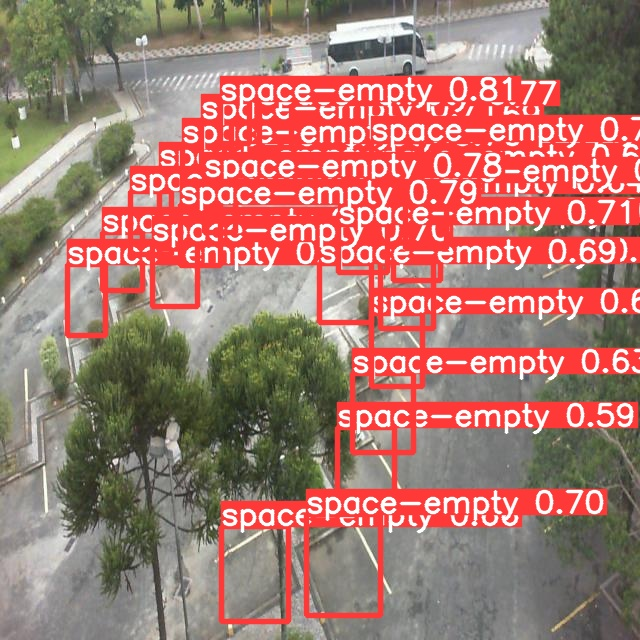

In [ ]:
import glob
import random
from IPython.display import Image, display

image_name = random.choice(glob.glob('/content/yolov5/runs/detect/exp/*.jpg'))
display(Image(filename=image_name))

In [ ]:
# 모델 내보내기
%cp runs/train/pklot_results/weights/best.pt /content/drive/MyDrive/

In [ ]:
# 모델 불러오기
%cp  /content/drive/MyDrive/best.pt /content/yolov5

- yolov5 pretrained 80개 구별 모델로 해보기

In [ ]:
%cd /content/yolov5

!python detect.py --weights yolov5s.pt --img 640 --conf 0.4 --source ./pklot/test/images

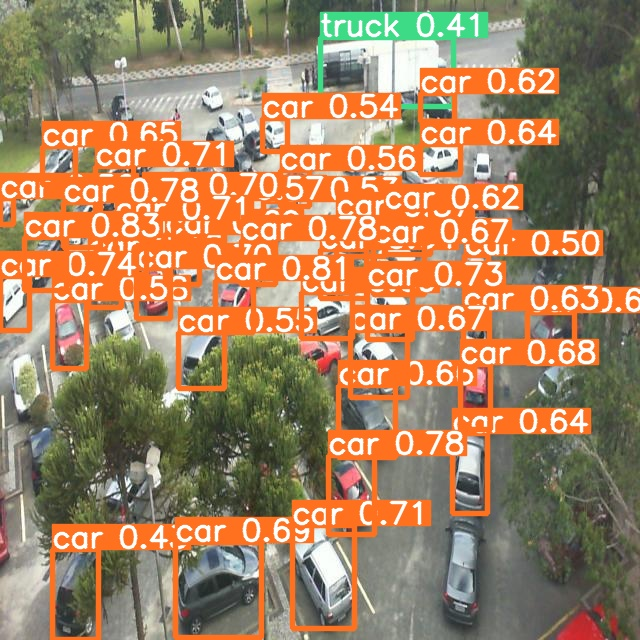

In [ ]:
import glob
import random
from IPython.display import Image, display

image_name = random.choice(glob.glob('/content/yolov5/runs/detect/exp/*.jpg'))
display(Image(filename=image_name))

- 저장한 모델을 불러와서 다시한번 실행해보기

In [ ]:
%cd /content/yolov5
!python detect.py --weights best.pt --img 640 --conf 0.4 --source ./pklot/test/images

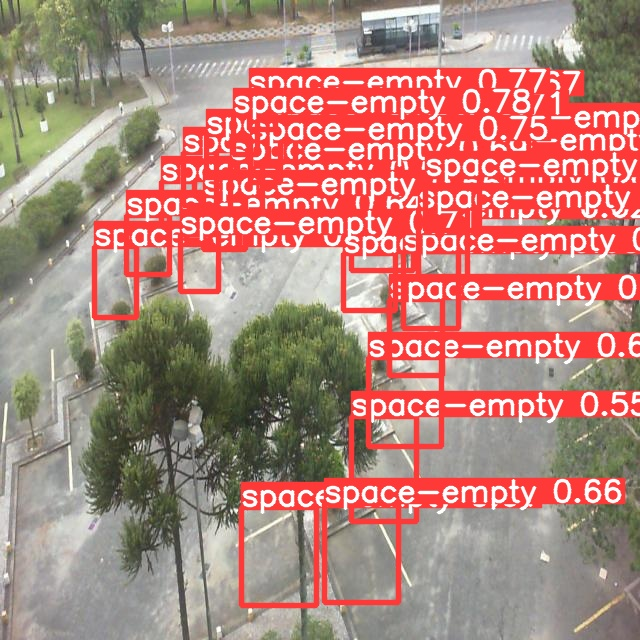

In [ ]:
import glob
import random
from IPython.display import Image, display

image_name = random.choice(glob.glob('/content/yolov5/runs/detect/exp4/*.jpg'))
display(Image(filename=image_name))